In [7]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/home/mila/l/leo.gagnon/latent_control')

from wandb import Api
import pandas as pd
from task import MetaLearningTask
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Prequential stuff

In [58]:
runs = Api().runs(path='leogagnon/latent_control', filters={'config.sweep_id': 'context_len_final'})
runs = [run.id for run in runs]

df = pd.DataFrame(columns=["method", "seed", "seq_id", "n_samples", "f_kl", "b_kl"])

N_RUNS = 30
C_LEN = 250

for id in runs:
    task = MetaLearningTask.from_wandb_id(id).cuda()
    if task.cfg.data.context_length == [2,200]:
        method = 'preq'
        task.set_to_checkpoint(step=12000)
    else:
        method = 'regular'
        task.set_to_checkpoint(step=6000)

    f, b = task.evaluate_pp(N_RUNS, C_LEN, 4)
    
    for i in range(N_RUNS):
        for j in range(C_LEN):
            df.loc[len(df)] = {"method": method, "seed": task.cfg.data.seed, "seq_id" : i, "n_samples": j, "f_kl": f[i,j].item(), "b_kl": b[i,j].item()}

number of parameters: 18.94M
Loading dataset...Done (11288/1000)
Loaded checkpoing : epoch=521,step=12000.ckpt
number of parameters: 18.94M
Loading dataset...Done (11288/1000)
Loaded checkpoing : epoch=521,step=12000.ckpt
number of parameters: 18.94M
Loading dataset...Done (11288/1000)
Loaded checkpoing : epoch=521,step=12000.ckpt
number of parameters: 18.94M
Loading dataset...Done (11288/1000)
Loaded checkpoing : epoch=521,step=12000.ckpt
number of parameters: 18.94M
Loading dataset...Done (11288/1000)
Loaded checkpoing : epoch=521,step=12000.ckpt
number of parameters: 18.94M
Loading dataset...Done (11288/1000)
Loaded checkpoing : epoch=260,step=6000.ckpt
number of parameters: 18.94M
Loading dataset...Done (11288/1000)
Loaded checkpoing : epoch=260,step=6000.ckpt
number of parameters: 18.94M
Loading dataset...Done (11288/1000)
Loaded checkpoing : epoch=260,step=6000.ckpt
number of parameters: 18.94M
Loading dataset...Done (11288/1000)
Loaded checkpoing : epoch=260,step=6000.ckpt
numbe

In [48]:
df.to_csv('prequential.csv')

<Axes: xlabel='n_samples', ylabel='b_kl'>

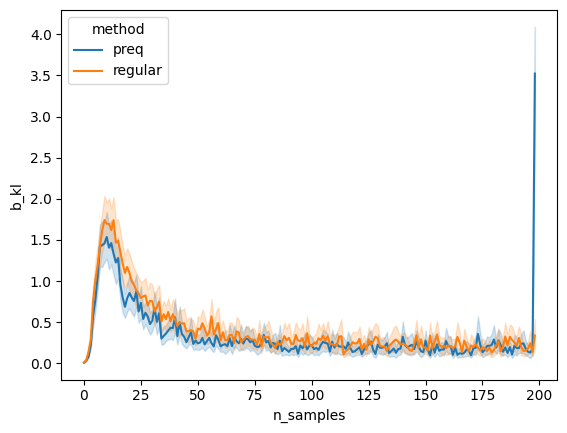

In [65]:
sns.lineplot(df.loc[df['n_samples'] < 199], x='n_samples', y='b_kl', hue='method')